<div style="border:solid green 2px; padding: 20px">
<b>Привет, Анна!</b>

Меня зовут Александр Пономаренко, и я буду проверять твой проект. Предлагаю общаться на «ты» :) Но если это не удобно - дай знать, и мы перейдем на "вы". 

Моя основная цель — не указать на совершенные тобою ошибки, а поделиться своим опытом и помочь тебе стать data science. Ты уже проделал большую работу над проектом, но давай сделаем его еще лучше. Ниже ты найдешь мои комментарии - **пожалуйста, не перемещай, не изменяй и не удаляй их**. Увидев у тебя ошибку, в первый раз я лишь укажу на ее наличие и дам тебе возможность самой найти и исправить ее. На реальной работе твой начальник будет поступать так же, а я пытаюсь подготовить тебя именно к работе аналитиком. Но если ты пока не справишься с такой задачей - при следующей проверке я дам более точную подсказку. Я буду использовать цветовую разметку:

<div class="alert alert-danger">
<b>Комментарий ревьюера ❌:</b> Так выделены самые важные замечания. Без их отработки проект не будет принят. </div>

<div class="alert alert-warning">
<b>Комментарий ревьюера ⚠️:</b> Так выделены небольшие замечания. Я надеюсь, что их ты тоже учтешь - твой проект от этого станет только лучше. Но настаивать на их отработке не буду.

</div>

<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b> Так я выделяю все остальные комментарии.</div>

Давай работать над проектом в диалоге: **если ты что-то меняешь в проекте или отвечаешь на мои комменатри — пиши об этом.** Мне будет легче отследить изменения, если ты выделишь свои комментарии:
<div class="alert alert-info"> <b>Комментарий студента:</b> Например, вот так.</div>

Всё это поможет выполнить повторную проверку твоего проекта оперативнее. 

<div class="alert alert-info"> <b>Комментарий студента:</b> Привет, Александр! Спасибо за такое стремительное ревью проекта и полезную библиотеку допматериалов. При переделке проекта у меня все рассыпалось, так что зависла с наведением порядка, а потом еще и захворала с температурой. В итоге пока в голове сумбур и неуверенность, что я правильно поняла твои подсказки и комментарии. </div>

<div class="alert alert-success">
<b>Комментарий ревьюера V2✔️:</b> Выздоравливай!!! И давай разбираться:)</div>

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Решающее-дерево" data-toc-modified-id="Решающее-дерево-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Решающее дерево</a></span></li><li><span><a href="#Логистическая-регрессия" data-toc-modified-id="Логистическая-регрессия-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Логистическая регрессия</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#Модель-CatBoost" data-toc-modified-id="Модель-CatBoost-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Модель CatBoost</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
# Импорт библиотек
import pandas as pd
import numpy as np
import nltk
import re
import spacy
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.metrics import f1_score
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, HalvingGridSearchCV
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

import warnings
warnings.filterwarnings('ignore')

In [2]:
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import WordNetLemmatizer 
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
# Загрузка данных
try:
    data = pd.read_csv('/datasets/toxic_comments.csv')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv')

In [4]:
data.head(10)

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
5,"""\n\nCongratulations from me as well, use the ...",0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,Your vandalism to the Matt Shirvington article...,0
8,Sorry if the word 'nonsense' was offensive to ...,0
9,alignment on this subject and which are contra...,0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b> Данные готовы:)</div>

Text(0.5, 1.0, 'Распределение комментариев по классам токсичности')

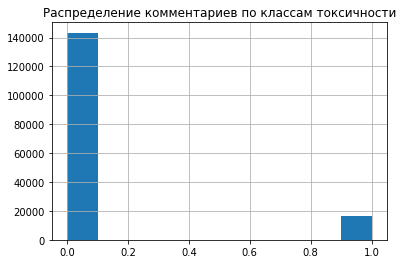

In [6]:
# Проверим распределение целевого признака
data['toxic'].hist()
plt.title('Распределение комментариев по классам токсичности')

<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b> Молодец, что проверяешь баланс классов:)</div>

In [7]:
data[data['toxic'] == 1].head(10)

,text,toxic
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
12,Hey... what is it..\n@ | talk .\nWhat is it......,1
16,"Bye! \n\nDon't look, come or think of comming ...",1
42,You are gay or antisemmitian? \n\nArchangel WH...,1
43,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1
44,I'm Sorry \n\nI'm sorry I screwed around with ...,1
51,GET FUCKED UP. GET FUCKEEED UP. GOT A DRINK T...,1
55,Stupid peace of shit stop deleting my stuff as...,1
56,=Tony Sidaway is obviously a fistfuckee. He lo...,1
58,My Band Page's deletion. You thought I was gon...,1


Многие токсичные комментарии пишутся в верхнем регистре, но это, пожалуй, не общее правило.

In [8]:
data['is_upper'] = data['text'].str.isupper()

In [9]:
print('Доля токсичных коментариев заглавными буквами: {0:.1%}'.format(
    data[data['is_upper'] == 1]['toxic'].mean()
))

Доля токсичных коментариев заглавными буквами: 66.7%


Перед обучением моделей подготовим признаки и целевой признак, запустив лемматизацию текстов.

In [10]:
#m = Mystem()

#def lemmatize_text(text):
#    text = text.lower()
#    lemm_text = "".join(m.lemmatize(text))
#    cleared_text = re.sub(r'[^a-zA-Z]', ' ', lemm_text) 
#    return " ".join(cleared_text.split())

#data['lemm_text'] = data['text'].apply(lemmatize_text)

#data = data.drop(['text'], axis=1)

<div class="alert alert-danger">
<b>Комментарий ревьюера ❌:</b> Обрати внимание, что mystem только для русского языка и тут бесполезна:(

+  https://webdevblog.ru/podhody-lemmatizacii-s-primerami-v-python/

</div>

<div class="alert alert-info"> <b>Комментарий студента:</b> Спасибо за суперважное замечание и подсказки по ссылке. Попробую переделать лемматизацию по WordNet</div>

In [11]:
# Функция для лемматизации и очистки комментариев
def lemma_by_spacy(text):
    text = text.lower()
    doc = nlp(text)
    doc = " ".join([token.lemma_ for token in doc])
    doc = re.sub(r'[^a-zA-Z ]',' ',doc)
  
    return " ".join(doc.split())

In [12]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b> Вот так можно следить за выполнением функции

```python
    
from tqdm import tqdm
tqdm.pandas()
data['text'] = data['text'].progress_apply(lemmatize_text) 
```
Где *lemmatize_text* - функция

</div>

In [13]:
#tqdm.pandas()
#data['text'] = data['text'].progress_apply(lambda x: lemmatize(clear_text(x)))

<div class="alert alert-info"> <b>Комментарий студента:</b> Крутая наглядная фича. Спасибо за рекомендацию. </div>

Выделим признаки для обучения моделей

In [14]:
target = data['toxic']
features = data['text']

#features_train, features_valid, target_train, target_valid = train_test_split(features, 
#                                                                              target, 
#                                                                              test_size=0.4, 
#                                                                              random_state=12345)
#features_valid, features_test, target_valid, target_test = train_test_split(features_valid, 
#                                                                            target_valid, 
#                                                                            test_size=0.5,
#                                                                            random_state=12345)

In [15]:
tqdm.pandas()
lemma = features.progress_apply(lemma_by_spacy)

100%|██████████| 159571/159571 [17:51<00:00, 148.98it/s]




<div class="alert alert-success">
<b>Комментарий ревьюера V2✔️:</b> Да, круто!!! Кстати, если у тебя есть GPU, то можно ускорить процесс:
    
```python
    import spacy
    activated = spacy.prefer_gpu()
    nlp = spacy.load("en_core_web_sm")
    
```

</div>                                                                            

<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b> Можно быстро разделить на train/valid/test, вот так:
    

```python
    from fast_ml.model_development import train_valid_test_split
    X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(df, target = 'target', 
                                                                            train_size=0.8, valid_size=0.1, test_size=0.1)
````

</div>                                                                            

<div class="alert alert-info"> <b>Комментарий студента:</b> Полезная штука. Буду с удовольствием использовать.</div>

<div class="alert alert-warning">
<b>Комментарий ревьюера ⚠️:</b> Только по сути тебе валидационная выборка не нужна, ты же используешь кросс валидацию. Данная выборка используется лишь для подбора лучших параметров

</div>

Разобьем датасет на обучающую и тестовую выборки. 

In [16]:
features_train, features_test, target_train, target_test = train_test_split(lemma, target, 
                                                                            test_size = 0.3, random_state = 12345)



<div class="alert alert-success">
<b>Комментарий ревьюера V2✔️:</b> Хорошо:)

</div>                                                                            

Очистим тексты от стоп-слов и ненужных символов. Создадим счетчик, указав в нем стоп-слова

In [17]:
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

count_tf_idf = TfidfVectorizer(stop_words=stopwords)

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Чтобы посчитать TF-IDF для корпуса текстов, вызовем функцию fit_transform() для обучающей выборки. Сразу приведем данные выборок к формату Unicode.

In [18]:
features_train = count_tf_idf.fit_transform(features_train)
#features_valid = count_tf_idf.transform(features_valid['lemm_text'].values.astype('U'))
features_test = count_tf_idf.transform(features_test)

<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b> Огонь, tfidf верно применила:)
</div>                                                                            

<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b> Можно поподбирать параметры комплексно:
    
    
```python
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopwords)),
    ('logreg', LogisticRegression(random_state=42)),
])
parameters = {
    'tfidf__max_df': (0.25, 0.5, 0.75),
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'logreg__C': [1,2,6]
}

grid_search_tune = RandomizedSearchCV(pipeline, parameters, cv=3, n_jobs=-1, scoring='f1', verbose=3)
grid_search_tune.fit(train_features, train_targets)
  
    
```
</div>                                                                            

In [19]:
# Формы тренировочной и тестовой выборок
print(features_train.shape)
#print(features_valid.shape)
print(features_test.shape)

(111699, 124480)
(47872, 124480)


Ограничим количество кроссвалидаций до 3 для ускорения процесса и проверим показатели на модели логистической регрессии.

In [20]:
classificator = LogisticRegression()
f1_train = cross_val_score(classificator, features_train, target_train, cv=3, scoring='f1').mean()
print('F1 на кросс-валидации', f1_train)

F1 на кросс-валидации 0.7001447631887121


<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b>  Есть еще вот такие методы подбора паарметров GridSearch/RandomizedSearch/Optuna/HalvingGridSearch:
    
    
+  https://towardsdatascience.com/automatic-hyperparameter-tuning-with-sklearn-gridsearchcv-and-randomizedsearchcv-e94f53a518ee
+  https://medium.com/databulls/tps-mar21-leaderboard-14-xgb-catboost-lgbm-optuna-cdffb5124368
+  https://towardsdatascience.com/faster-hyperparameter-tuning-with-scikit-learn-71aa76d06f12
+  https://scikit-learn.ru/3-2-tuning-the-hyper-parameters-of-an-estimator/ 

Используй их, чтобы по подобрать параметры для наших моделей. Например,для LogisticRegression можно покрутить параметр C. а так можно сбалансировать классы
    
P.S ниже делаешь,ок
</div>                                                                           

Классы разбалансированы. Уберем часть объектов бОльшего класса с помощью техники downsampling.

<div class="alert alert-success">
<b>Комментарий ревьюера V2✔️:</b> По хорошему необходимо попробовать несколько методов балансировки:
    
+  https://towardsdatascience.com/5-techniques-to-work-with-imbalanced-data-in-machine-learning-80836d45d30c
    
    
Но мне кажется, тут лучше подойдет class_weight=balanced. Такое чувство, что модели просто переучиваются
</div>                                                                           

<div class="alert alert-info"> <b>Комментарий студента V2:</b> Перевела все модели с downsampling'а на class_weight = 'balanced'. Вроде в таком варианте результаты стали походить на достоверные. Другие методы балансировки попробовала, но решила действовать проще. </div>

<div class="alert alert-success">
<b>Комментарий ревьюера V3✔️:</b> Хорошо:)</div>

In [21]:
data_train = data.iloc[target_train.index]

target_train_class_zero = data_train[data_train['toxic'] == 0]['toxic']
target_train_class_one = data_train[data_train['toxic'] == 1]['toxic']

target_train_class_zero_downsample = target_train_class_zero.sample(target_train_class_one.shape[0],
                                                                    random_state=12345)
target_train_downsample = pd.concat([target_train_class_zero_downsample, target_train_class_one])

In [22]:
features_train_downsample = data.iloc[target_train_downsample.index]
features_train_downsample, target_train_downsample = shuffle(features_train_downsample,
                                                             target_train_downsample,
                                                             random_state=12345)
features_train_downsample = count_tf_idf.transform(features_train_downsample['text']
                                                   .values.astype('U'))

In [23]:
classificator = LogisticRegression()
f1_train_downsample = cross_val_score(classificator,
                      features_train_downsample, 
                      target_train_downsample, 
                      cv=3, 
                      scoring='f1').mean()
print('F1 на кросс-валидации с уменьшением классов', f1_train_downsample)

F1 на кросс-валидации с уменьшением классов 0.8770088578293147


**Вывод**

В ходе предобработки путем токенизации и лемматизации подготовлены признаки для обучения. Выборка разделена на обучающую и тестовую в соотношении 70:30.

Судя по анализу метрики F1, стоит использовать классификатор с учетом веса классов.

## Обучение

Для обучения выберем следующие модели:

* Решающее дерево
* Логистическая регрессия
* Случайный лес
* CatBoost

### Решающее дерево

In [24]:
# Подберем гиперпараметры с помощью GridSearchCV
# classificator = DecisionTreeClassifier()
#hyperparams = [{'max_depth':[x for x in range(10,101,2)],
#                'random_state':[12345]}]

# clf = GridSearchCV(classificator, hyperparams, scoring='f1', cv=3)
# clf.fit(features_train_downsample, target_train_downsample)
# clf.best_params_

In [25]:
# clf.best_score_

<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b> GridSearchCV хорош когда у нас мало данных или немного параметров нужно прогнать. Попробуй HalvingGridSearchCV , он работает гораздо быстрее:) или HalvingRandomSearchCV:
    
+  https://runebook.dev/ru/docs/scikit_learn/modules/generated/sklearn.model_selection.halvinggridsearchcv
+  https://runebook.dev/ru/docs/scikit_learn/auto_examples/model_selection/plot_successive_halving_iterations
    
</div>



<div class="alert alert-info"> <b>Комментарий студента:</b> Попробовала (ниже) HalvingGridSearch для решающего дерева, но не так много параметров исследовала, так что результаты получила посредственные.

Зато решила по подсказке применить clf.best_score_. Честно говоря, результат не выглядит достоверно, но пока оставлю так.</div>

<div class="alert alert-success">
<b>Комментарий ревьюера V2✔️:</b> Если ты про большое число, то все нормально. К сожалению, для валидации, тоже используется выборка где баланс класс выровнен и итоге мы получим более положительный результат, чем на тесте. Поэтому лучше использовать PredefinedSplit для достоверности:
    
+ https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.PredefinedSplit.html
    
+  https://stackoverflow.com/questions/31948879/using-explicit-predefined-validation-set-for-grid-search-with-sklearn - тут прям код есть

</div>



In [26]:
# Подберем гиперпараметры с помощью HalvingGridSearchCV
classificator = DecisionTreeClassifier(class_weight = 'balanced')
param_grid = {"max_depth": [10, 101, 2]}
search = (HalvingGridSearchCV(classificator, param_grid, resource='max_features', max_resources=10, 
                              cv=3, random_state=12345))
search.fit(features_train, target_train)
search.best_params_

{'max_depth': 2, 'max_features': 9}

In [27]:
f1_dt = search.best_score_
print(f1_dt)

0.3680158282527149


In [28]:
#classificator = DecisionTreeClassifier()
#classificator.set_params(max_depth = None, max_features = 10)
#classificator.fit(features_train, target_train)
#target_predict = classificator.predict(features_valid)

#f1_dt_cv = cross_val_score(classificator, features_train, target_train, cv=3, scoring='f1').mean()
#f1_dt_valid = f1_score(target_valid, target_predict)
#print('F1 на кросс-валидации', f1_dt_cv)
#print('F1 на валидационной выборке', f1_dt_valid)

<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b> Можешь воспользоваться: clf.best_score_ и не обучать еще раз, и не проверять на валидацинной выборке(ее лучше соедини с обучающей и используй для обучения) 
</div>                                                                           

### Логистическая регрессия

In [29]:
param_grid = {'solver': ['liblinear', 'newton-cg', 'sag', 'saga', 'lbfgs'],
              'C': [0.1, 1, 10],
              'class_weight': ['balanced']}
search = (HalvingGridSearchCV(LogisticRegression(), param_grid,
                            scoring = 'f1', cv=3, random_state=12345))
search.fit(features_train, target_train)
search.best_params_

{'C': 1, 'class_weight': 'balanced', 'solver': 'lbfgs'}

In [30]:
f1_lr = search.best_score_
print(f1_lr)

0.7501033090205939


<div class="alert alert-success">
<b>Комментарий ревьюера V3✔️:</b> Отлично:)</div>

In [31]:
# Подберем гиперпараметры
#classificator = LogisticRegression()
#hyperparams = [{'solver':['newton-cg', 'lbfgs', 'liblinear'],
#                'C':[0.1, 1, 10]}]

#clf = GridSearchCV(classificator, hyperparams, scoring='f1', cv=3)
#clf.fit(features_train_downsample, target_train_downsample)
#clf.best_params_

In [32]:
#classificator = LogisticRegression()
#classificator.set_params(C = 10, class_weight = 'balanced', solver = 'saga')
#classificator.fit(features_train, target_train)
#target_predict = classificator.predict(features_valid)

#f1_lr_cv = cross_val_score(classificator, features_train, target_train, cv=3, scoring='f1').mean()
#f1_lr_valid = f1_score(target_valid, target_predict)
#print('F1 на кросс-валидации', f1_lr_cv)
#print('F1 на валидационной выборке', f1_lr_valid)

### Случайный лес

In [33]:
# Подберем гиперпараметры
# classificator = RandomForestClassifier()
#hyperparams = [{'n_estimators':[10, 200, 10],
#                'max_depth':[2, 200, 10]}]

#clf = GridSearchCV(classificator, hyperparams, scoring='f1', cv=3)
#clf.fit(features_train_downsample, target_train_downsample)
#clf.best_params_

In [34]:
param_grid = {'n_estimators':[10, 200, 10],
              'max_depth':[2, 100, 10],
              'class_weight': ['balanced']}
search = (HalvingGridSearchCV(RandomForestClassifier(), param_grid, 
                            scoring = 'f1', cv=3, random_state=12345))
search.fit(features_train, target_train)
search.best_params_

{'class_weight': 'balanced', 'max_depth': 100, 'n_estimators': 200}

In [35]:
f1_rf = search.best_score_
print(f1_rf)

0.5469888772785895


In [36]:
# classificator = RandomForestClassifier()
# classificator.set_params(max_depth = 400, n_estimators = 400)
# classificator.fit(features_train, target_train)
# target_predict = classificator.predict(features_valid)
# f1_rf_cv = cross_val_score(classificator, features_train, target_train, cv=3, scoring='f1').mean()
# f1_rf_valid = f1_score(target_valid, target_predict)
# print('F1 на кросс-валидации', f1_rf_cv)
# print('F1 на валидационной выборке', f1_rf_valid)

<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b>Да...древовидные модели тут плохо работают
</div>                                                                           

### Модель CatBoost

In [37]:
param_grid = {'iterations':[100, 200, 50],
              'learning_rate':[0.1, 1.0, 0.2]}
search = (HalvingGridSearchCV(CatBoostClassifier(), param_grid, verbose = 20,
                            scoring = 'f1', cv=3, random_state=12345))
search.fit(features_train, target_train)
search.best_params_

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 12411
max_resources_: 111699
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 9
n_resources: 12411
Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3; 1/9] START iterations=100, learning_rate=0.1...........................
0:	learn: 0.5999579	total: 355ms	remaining: 35.1s
1:	learn: 0.5197036	total: 576ms	remaining: 28.2s
2:	learn: 0.4601355	total: 798ms	remaining: 25.8s
3:	learn: 0.4151490	total: 1.02s	remaining: 24.4s
4:	learn: 0.3812665	total: 1.24s	remaining: 23.6s
5:	learn: 0.3550014	total: 1.46s	remaining: 22.9s
6:	learn: 0.3330446	total: 1.68s	remaining: 22.3s
7:	learn: 0.3140495	total: 1.91s	remaining: 22s
8:	learn: 0.2993969	total: 2.15s	remaining: 21.7s
9:	learn: 0.2889785	total: 2.38s	remaining: 21.4s
10:	learn: 0.2793645	total: 2.61s	remaining: 21.1s
11:	learn: 0.2708005	total: 2.83s	remaining: 20.7s
12:	learn: 0.2625543	total: 3.05s	remaining: 20.4s
13:

{'iterations': 50, 'learning_rate': 1.0}

In [38]:
f1_cb = search.best_score_
print(f1_cb)

0.7410210032652431


In [39]:
# classificator = CatBoostClassifier(verbose=False, iterations=300, learning_rate = 0.2)
# classificator.fit(features_train, target_train)
# target_predict = classificator.predict(features_valid)
# f1_cb_cv = cross_val_score(classificator, features_train, target_train, cv=3, scoring='f1').mean()
# f1_cb_valid = f1_score(target_valid, target_predict)
# print('F1 на кросс-валидации', f1_cb_cv)
# print('F1 на валидационной выборке', f1_cb_valid)

Сведем в единой таблице данные валидации обученных моделей.

In [40]:
index = ['Решающее дерево',
         'Логистическая регрессия',
         'Случайный лес',
         'CatBoost']
data = {'F1 на кросс-валидации':[f1_dt, f1_lr, f1_rf, f1_cb]}

scores = pd.DataFrame(data=data, index=index)
scores['Выполнение условия'] = scores['F1 на кросс-валидации'] > 0.75
scores

,F1 на кросс-валидации,Выполнение условия
Решающее дерево,0.368016,False
Логистическая регрессия,0.750103,True
Случайный лес,0.546989,False
CatBoost,0.741021,False


<div class="alert alert-info"> <b>Комментарий студента V2:</b> В третьей итерации проекта получены более достоверные результаты с единственной успешной моделью, достигшей заданного критерия качества по метрике F1, - логистической регрессией.</div>

<div class="alert alert-success">
<b>Комментарий ревьюера V3✔️:</b> Еще SGDClassifier должен выбить неплохие результаты) Молодец, что смогла побить нужное значение:)</div>

<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b> У тебя получается роль тестовой выборки выполняла валидационная:( ой, подправь, пожалуйста
    
+  следует объединить train и valid
+  test используй для тестирования:) 
    
И молодец, что смогла побить нужное значение:)
    
</div>

<div class="alert alert-danger">
<b>Комментарий ревьюера V2❌:</b> Также необходимо провести тестирование лучшей модели:( </div>

<div class="alert alert-info"> <b>Комментарий студента V2:</b> Проведем тестирование самой успешной модели на тестовых данных</div>

In [42]:
model = LogisticRegression(class_weight = 'balanced', C = 1, solver = 'lbfgs')
model.fit(features_train, target_train)
print('F1 лучшей модели на тестовых данных:', f1_score(target_test, model.predict(features_test)))

F1 лучшей модели на тестовых данных: 0.7531297847428624


<div class="alert alert-success">
<b>Комментарий ревьюера V3✔️:</b> Огонь:)</div>

## Выводы

В ходе работы над проектом выполнены следующие шаги:

* Исходные данные подготовлены к обучению с использованием токенизации и лемматизации текстов
* Датасет поделен на обучающую и тестовую выборки в отношении 70:30
* Обучены модели решающего дерева, логистической регрессии, случайного леса и CatBoost с балансировкой классов. 

Лучший показатель качества по метрике F1=0.75 показала модель логистической регрессии. Данный результат подтверждается при работе модели на тестовых данных.

<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b> 

Для работы с текстами используют и другие подходы. Например, сейчас активно используются RNN (LSTM) и трансформеры (BERT и другие с улицы Сезам, например, ELMO). НО! Они не являются панацеей, не всегда они нужны, так как и TF-IDF или Word2Vec + модели из классического ML тоже могут справляться. \
BERT тяжелый, существует много его вариаций для разных задач, есть готовые модели, есть надстройки над библиотекой transformers. Если, обучать BERT на GPU (можно в Google Colab или Kaggle), то должно быть побыстрее.\
https://huggingface.co/transformers/model_doc/bert.html \
https://t.me/renat_alimbekov \
https://colah.github.io/posts/2015-08-Understanding-LSTMs/ - Про LSTM \
https://web.stanford.edu/~jurafsky/slp3/10.pdf - про энкодер-декодер модели, этеншены\
https://pytorch.org/tutorials/beginner/transformer_tutorial.html - официальный гайд
по трансформеру от создателей pytorch\
https://transformer.huggingface.co/ - поболтать с трансформером \
Библиотеки: allennlp, fairseq, transformers, tensorflow-text — множество реализованных
методов для трансформеров методов NLP \
Word2Vec https://radimrehurek.com/gensim/models/word2vec.html 
    
</div>

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Данные загружены и подготовлены
- [ ]  Модели обучены
- [ ]  Значение метрики *F1* не меньше 0.75
- [ ]  Выводы написаны

<font color='blue'><b>Итоговый комментарий ревьюера</b></font>
<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b>Анна, получился хороший проект! 
    
Если есть  если есть какие либо вопросы я с удовольствием на них отвечу:) <br> Исправь, пожалуйста, замечания и жду проект на следующую проверку:) </div>


<div class="alert alert-success">
<b>Комментарий ревьюера V3✔️:</b> Удачи в следующих проектах:)


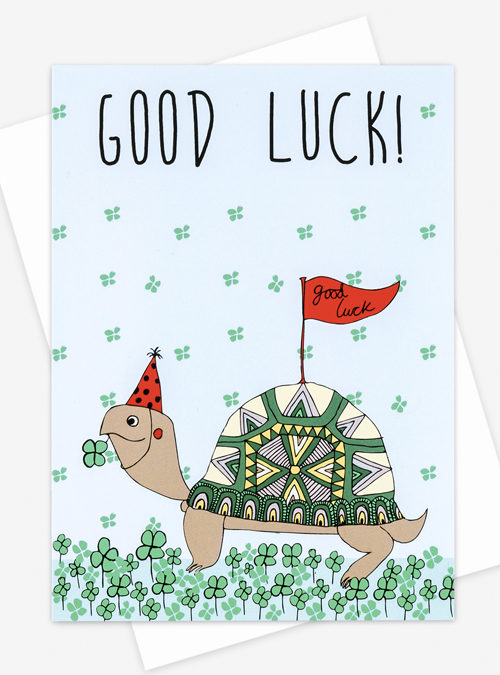

</div>